<a href="https://colab.research.google.com/github/Rhf77/MLproject/blob/main/Copy_of_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [33]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [34]:
!pip install xgboost tensorflow statsmodels
!pip install tensorflow

In [37]:
folder_path ='/content/drive/MyDrive/MLPro'   # Update the folder path as per your setup

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Process each file
for file in csv_files:
    print(f"Processing file: {file}")

    df = pd.read_csv(file)

Processing file: /content/drive/MyDrive/MLPro/campus_meta.csv
Processing file: /content/drive/MyDrive/MLPro/calender.csv
Processing file: /content/drive/MyDrive/MLPro/gas_consumption.csv
Processing file: /content/drive/MyDrive/MLPro/events.csv
Processing file: /content/drive/MyDrive/MLPro/building_meta.csv
Processing file: /content/drive/MyDrive/MLPro/building_consumption.csv
Processing file: /content/drive/MyDrive/MLPro/building_submeter_consumption.csv
Processing file: /content/drive/MyDrive/MLPro/nmi_consumption.csv
Processing file: /content/drive/MyDrive/MLPro/water_consumption.csv
Processing file: /content/drive/MyDrive/MLPro/nmi_meta.csv
Processing file: /content/drive/MyDrive/MLPro/weather_data.csv


In [39]:
# Define file paths
base_path = "/content/drive/MyDrive/MLPro/"

files = {
    "campus_meta": "campus_meta.csv",
    "calendar": "calender.csv",
    "gas": "gas_consumption.csv",
    "events": "events.csv",
    "building_meta": "building_meta.csv",
    "building_consumption": "building_consumption.csv",
    "building_submeter": "building_submeter_consumption.csv",
    "nmi_consumption": "nmi_consumption.csv",
    "water": "water_consumption.csv",
    "nmi_meta": "nmi_meta.csv",
    "weather": "weather_data.csv"
}

# Load all files
dfs = {name: pd.read_csv(base_path + fname, engine='python') for name, fname in files.items()}


In [40]:
# Print column names to debug
for name, df in dfs.items():
    print(f"{name} columns: {df.columns.tolist()}")

campus_meta columns: ['id', 'name', 'capacity']
calendar columns: ['date', 'is_holiday', 'is_semester', 'is_exam']
gas columns: ['campus_id', 'timestamp', 'consumption']
events columns: ['meter_id', 'event_type', 'date', 'event_description']
building_meta columns: ['campus_id', 'id', 'built_year', 'category', 'gross_floor_area', 'room_area', 'capacity']
building_consumption columns: ['campus_id', 'meter_id', 'timestamp', 'consumption']
building_submeter columns: ['building_id', 'id', 'campus_id', 'timestamp', 'consumption', 'current', 'voltage', 'power', 'power_factor']
nmi_consumption columns: ['campus_id', 'meter_id', 'timestamp', 'consumption', 'demand_kW', 'demand_kVA']
water columns: ['campus_id', 'meter_id', 'timestamp', 'consumption']
nmi_meta columns: ['id', 'campus_id', 'peak_demand']
weather columns: ['campus_id', 'timestamp', 'apparent_temperature', 'air_temperature', 'dew_point_temperature', 'relative_humidity', 'wind_speed', 'wind_direction']


In [42]:
# Step 1: Convert 'timestamp' columns to datetime with UTC
timestamped_keys = ["gas", "water", "nmi_consumption", "building_submeter", "weather"]
for key in timestamped_keys:
    dfs[key]['timestamp'] = pd.to_datetime(dfs[key]['timestamp'], utc=True)

In [43]:
# Step 2: Resampling & Filling function with deduplication
def resample_and_fill(df, time_col, freq='h'):
    df = df.dropna(subset=[time_col])
    df = df.sort_values(by=time_col)
    df = df.drop_duplicates(subset=[time_col])  # <- KEY FIX
    df = df.set_index(time_col)
    df_resampled = df.resample(freq).ffill().bfill()
    return df_resampled

In [44]:
# Apply to datasets with timestamp
df_gas = resample_and_fill(dfs["gas"], 'timestamp')
df_water = resample_and_fill(dfs["water"], 'timestamp')
df_nmi = resample_and_fill(dfs["nmi_consumption"], 'timestamp')
df_weather = resample_and_fill(dfs["weather"], 'timestamp')
df_building = resample_and_fill(dfs["building_submeter"], 'timestamp')

In [45]:
# Step 3: Remove Outliers using IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_gas = remove_outliers_iqr(df_gas, ['consumption'])
df_water = remove_outliers_iqr(df_water, ['consumption'])
df_nmi = remove_outliers_iqr(df_nmi, ['consumption', 'demand_kW', 'demand_kVA'])
df_building = remove_outliers_iqr(df_building, ['consumption', 'current', 'voltage', 'power', 'power_factor'])

In [46]:
# Step 4: Time Feature Engineering
def add_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'] >= 5
    return df

In [47]:
df_gas = add_time_features(df_gas)
df_water = add_time_features(df_water)
df_nmi = add_time_features(df_nmi)
df_weather = add_time_features(df_weather)
df_building = add_time_features(df_building)

print("✅ All timestamped datasets cleaned, resampled, and feature-engineered.")

✅ All timestamped datasets cleaned, resampled, and feature-engineered.


In [48]:
df_gas.to_csv("cleaned_gas.csv")
df_water.to_csv("cleaned_water.csv")
df_nmi.to_csv("cleaned_nmi.csv")
df_weather.to_csv("cleaned_weather.csv")
df_building.to_csv("cleaned_building.csv")

In [49]:
# Print columns of df_gas, df_water, and df_building
print("Columns in df_gas:")
print(df_gas.columns)

print("\nColumns in df_water:")
print(df_water.columns)

print("\nColumns in df_building:")
print(df_building.columns)


Columns in df_gas:
Index(['campus_id', 'consumption', 'hour', 'dayofweek', 'month', 'is_weekend'], dtype='object')

Columns in df_water:
Index(['campus_id', 'meter_id', 'consumption', 'hour', 'dayofweek', 'month',
       'is_weekend'],
      dtype='object')

Columns in df_building:
Index(['building_id', 'id', 'campus_id', 'consumption', 'current', 'voltage',
       'power', 'power_factor', 'hour', 'dayofweek', 'month', 'is_weekend'],
      dtype='object')


In [50]:
def train_test_split_horizon(df, horizon, target_col='consumption'):
    df = df.sort_index()
    # Use enough data for training, at least horizon + some buffer
    min_data_points = horizon + 2 * horizon  # Example: horizon + 2 times horizon for training
    df = df[-min_data_points:]
    train_size = len(df) - horizon
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    X_train, y_train = train.drop(columns=[target_col]), train[target_col]
    X_test, y_test = test.drop(columns=[target_col]), test[target_col]
    return X_train, X_test, y_train, y_test

In [51]:
def evaluate_model(model, X_test, y_test):
    if hasattr(model, 'forecast'):
        print("Using forecast method")
        predictions = model.forecast(steps=len(y_test))
    else:
        print("Using predict method")
        predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse



In [52]:
# TCN model builder
def build_tcn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [53]:
# Define horizons (in hours)
horizons = {
    "short_1d": 24,
    "medium_7d": 168,
    "long_30d": 720
}

In [54]:
# To store RMSE values for plotting
rmse_results = {
    'Model': [],
    'RMSE': [],
    'Dataset': [],
    'Horizon': []
}

In [55]:
# Iterate through the datasets and horizons, evaluate the models and collect RMSE
for df_name, df in zip(['df_gas', 'df_water', 'df_building'], [df_gas, df_water, df_building]):
    for horizon_name, horizon in horizons.items():
        print(f"--- {df_name.upper()} | {horizon_name.upper()} FORECAST ---")

        # Prepare train/test
        X_train, X_test, y_train, y_test = train_test_split_horizon(df, horizon)

        # 1. ARIMA - Reduced model order
        try:
            arima_model = ARIMA(y_train, order=(1, 1, 1))
            arima_fit = arima_model.fit()
            arima_rmse = evaluate_model(arima_fit, X_test, y_test)
            print(f"ARIMA RMSE: {arima_rmse:.4f}")
            rmse_results['Model'].append('ARIMA')
            rmse_results['RMSE'].append(arima_rmse)
            rmse_results['Dataset'].append(df_name)
            rmse_results['Horizon'].append(horizon_name)
        except np.linalg.LinAlgError:
            print("ARIMA model failed to converge.")

        # 2. SARIMA
        sarima_model = SARIMAX(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 24))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_rmse = evaluate_model(sarima_fit, X_test, y_test)
        print(f"SARIMA RMSE: {sarima_rmse:.4f}")
        rmse_results['Model'].append('SARIMA')
        rmse_results['RMSE'].append(sarima_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # 3. Exponential Smoothing
        es_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=24)
        es_fit = es_model.fit()
        es_rmse = evaluate_model(es_fit, X_test, y_test)
        print(f"Exp. Smoothing RMSE: {es_rmse:.4f}")
        rmse_results['Model'].append('Exp. Smoothing')
        rmse_results['RMSE'].append(es_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # 4. Random Forest
        rf_model = RandomForestRegressor(n_estimators=100)
        rf_model.fit(X_train, y_train)
        rf_rmse = evaluate_model(rf_model, X_test, y_test)
        print(f"Random Forest RMSE: {rf_rmse:.4f}")
        rmse_results['Model'].append('Random Forest')
        rmse_results['RMSE'].append(rf_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # 5. XGBoost
        xgb_model = xgb.XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train, y_train)
        xgb_rmse = evaluate_model(xgb_model, X_test, y_test)
        print(f"XGBoost RMSE: {xgb_rmse:.4f}")
        rmse_results['Model'].append('XGBoost')
        rmse_results['RMSE'].append(xgb_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # Convert to NumPy arrays with correct dtype
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        # Reshape for deep learning
        X_train_dl = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_dl = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

        # 6. LSTM
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        lstm_model.add(Dense(1))
        lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        lstm_model.fit(X_train_dl, y_train, epochs=20, batch_size=32, verbose=0)
        lstm_rmse = evaluate_model(lstm_model, X_test_dl, y_test)
        print(f"LSTM RMSE: {lstm_rmse:.4f}")
        rmse_results['Model'].append('LSTM')
        rmse_results['RMSE'].append(lstm_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # 7. GRU
        gru_model = Sequential()
        gru_model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        gru_model.add(Dense(1))
        gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        gru_model.fit(X_train_dl, y_train, epochs=20, batch_size=32, verbose=0)
        gru_rmse = evaluate_model(gru_model, X_test_dl, y_test)
        print(f"GRU RMSE: {gru_rmse:.4f}")
        rmse_results['Model'].append('GRU')
        rmse_results['RMSE'].append(gru_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        # 8. TCN
        tcn_model = build_tcn_model((X_train.shape[1], 1))
        tcn_model.fit(X_train_dl, y_train, epochs=20, batch_size=32, verbose=0)
        tcn_rmse = evaluate_model(tcn_model, X_test_dl, y_test)
        print(f"TCN RMSE: {tcn_rmse:.4f}")
        rmse_results['Model'].append('TCN')
        rmse_results['RMSE'].append(tcn_rmse)
        rmse_results['Dataset'].append(df_name)
        rmse_results['Horizon'].append(horizon_name)

        print(f"Finished Forecasting for {df_name}\n")

# Convert RMSE results to DataFrame
df_rmse = pd.DataFrame(rmse_results)

--- DF_GAS | SHORT_1D FORECAST ---
Using forecast method
ARIMA RMSE: 0.1161


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Using forecast method
SARIMA RMSE: 0.5681
Using forecast method
Exp. Smoothing RMSE: 0.5657
Using predict method
Random Forest RMSE: 0.1183
Using predict method
XGBoost RMSE: 0.1186


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
LSTM RMSE: 0.4708


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
GRU RMSE: 0.1862


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
TCN RMSE: 0.3852
Finished Forecasting for df_gas

--- DF_GAS | MEDIUM_7D FORECAST ---
Using forecast method
ARIMA RMSE: 8.2969
Using forecast method
SARIMA RMSE: 4.7510
Using forecast method
Exp. Smoothing RMSE: 3.9286
Using predict method
Random Forest RMSE: 2.9682
Using predict method
XGBoost RMSE: 3.6023


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM RMSE: 15.8496


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
GRU RMSE: 15.2037


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TCN RMSE: 14.7592
Finished Forecasting for df_gas

--- DF_GAS | LONG_30D FORECAST ---
Using forecast method
ARIMA RMSE: 10.3642
Using forecast method
SARIMA RMSE: 11.9988
Using forecast method
Exp. Smoothing RMSE: 10.6345
Using predict method
Random Forest RMSE: 4.5532
Using predict method
XGBoost RMSE: 4.5236


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM RMSE: 5.2322


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GRU RMSE: 5.1959


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
TCN RMSE: 4.6469
Finished Forecasting for df_gas

--- DF_WATER | SHORT_1D FORECAST ---
Using forecast method
ARIMA RMSE: 171.9390


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Using forecast method
SARIMA RMSE: 353.5529
Using forecast method
Exp. Smoothing RMSE: 261.9162


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
Random Forest RMSE: 162.9873
Using predict method
XGBoost RMSE: 174.0555
Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
LSTM RMSE: 183.4908


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
GRU RMSE: 202.2155


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
TCN RMSE: 184.5680
Finished Forecasting for df_water

--- DF_WATER | MEDIUM_7D FORECAST ---
Using forecast method
ARIMA RMSE: 128.6195


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  

Using forecast method
SARIMA RMSE: 128.6195
Using forecast method
Exp. Smoothing RMSE: 128.6195


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Using predict method
Random Forest RMSE: 128.6195
Using predict method
XGBoost RMSE: 128.6195


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
LSTM RMSE: 133.6326


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
GRU RMSE: 132.7425


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TCN RMSE: 138.3940
Finished Forecasting for df_water

--- DF_WATER | LONG_30D FORECAST ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
ARIMA RMSE: 89.9892


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
SARIMA RMSE: 74.6665


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
Exp. Smoothing RMSE: 439.2539


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Using predict method
Random Forest RMSE: 42.7652
Using predict method
XGBoost RMSE: 41.0625


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM RMSE: 53.9241


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
GRU RMSE: 53.7444


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
TCN RMSE: 54.3647
Finished Forecasting for df_water

--- DF_BUILDING | SHORT_1D FORECAST ---
Using forecast method
ARIMA RMSE: 0.4827


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

Using forecast method
SARIMA RMSE: 0.5713
Using forecast method
Exp. Smoothing RMSE: 0.5455


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Using predict method
Random Forest RMSE: 0.0757
Using predict method
XGBoost RMSE: 0.1480


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
LSTM RMSE: 0.7061


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
GRU RMSE: 0.5921


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
TCN RMSE: 2.5218
Finished Forecasting for df_building

--- DF_BUILDING | MEDIUM_7D FORECAST ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
ARIMA RMSE: 0.5126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
SARIMA RMSE: 0.5354
Using forecast method


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/py

Exp. Smoothing RMSE: 0.5214
Using predict method
Random Forest RMSE: 0.0085
Using predict method
XGBoost RMSE: 0.0142


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
LSTM RMSE: 0.0510


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
GRU RMSE: 0.0612


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
TCN RMSE: 0.7411
Finished Forecasting for df_building

--- DF_BUILDING | LONG_30D FORECAST ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
ARIMA RMSE: 0.5096


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
SARIMA RMSE: 0.5176


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using forecast method
Exp. Smoothing RMSE: 0.4966


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Using predict method
Random Forest RMSE: 0.0028
Using predict method
XGBoost RMSE: 0.0085


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM RMSE: 0.0089


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
GRU RMSE: 0.0303


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using predict method
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TCN RMSE: 0.3957
Finished Forecasting for df_building



##################################################

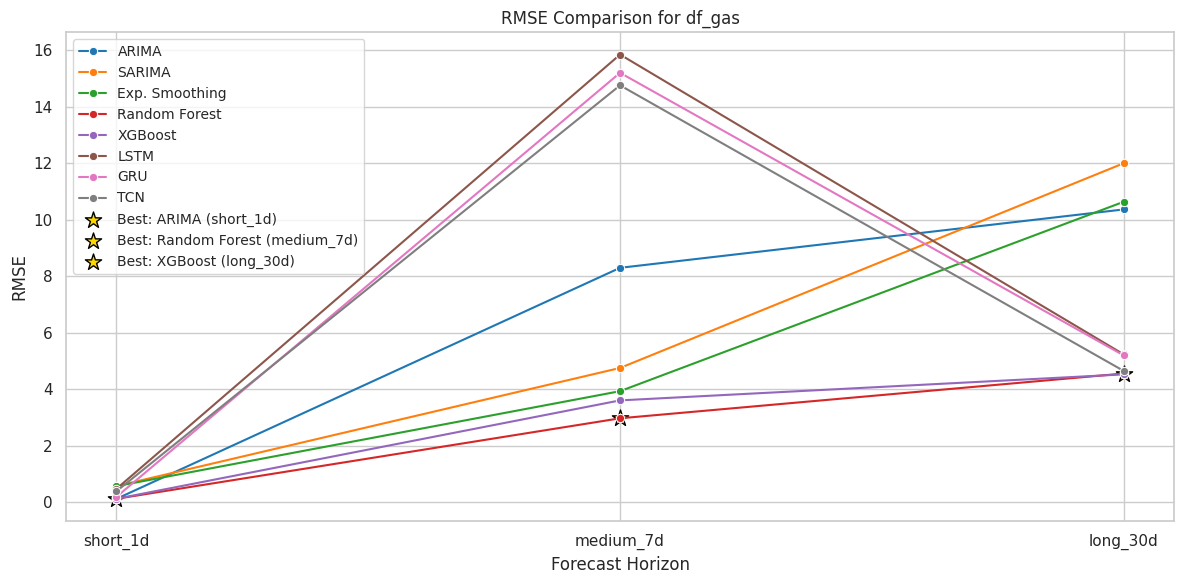

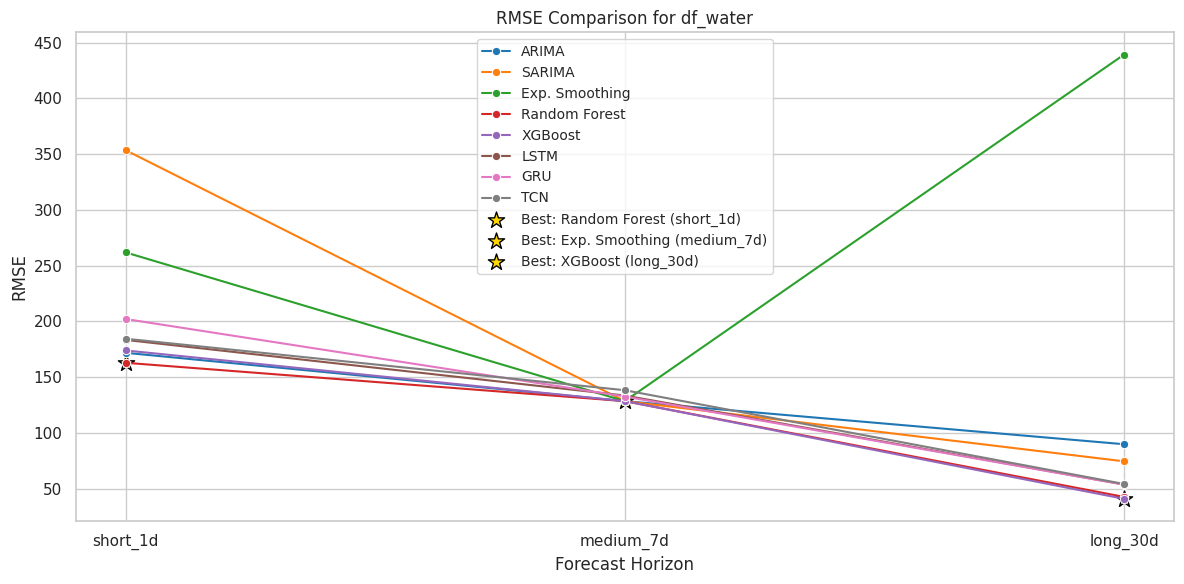

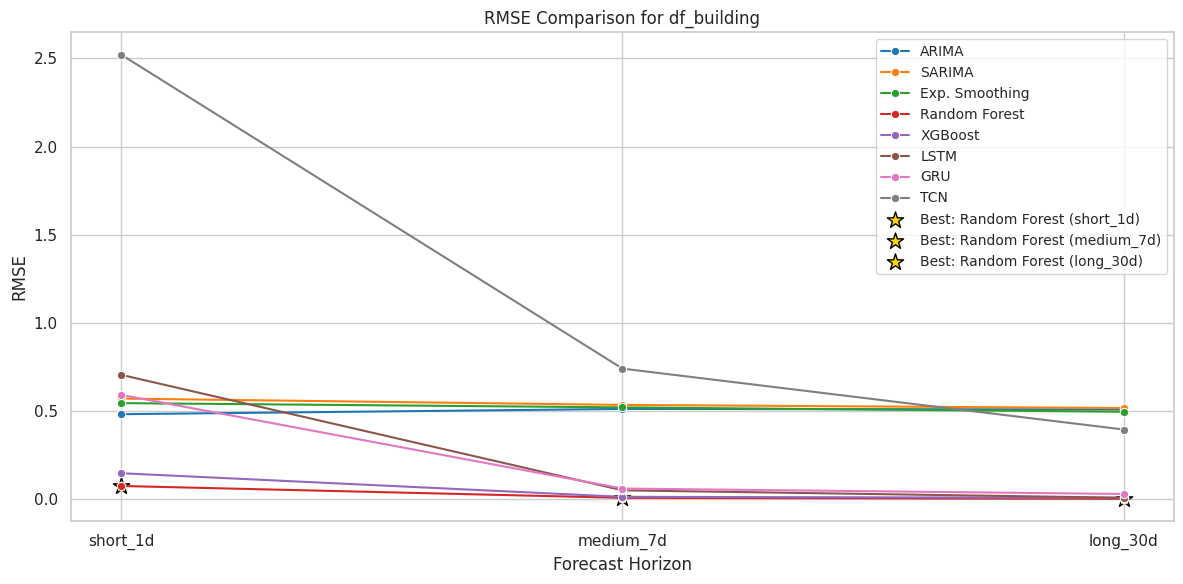

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert RMSE results into a DataFrame
rmse_df = pd.DataFrame(rmse_results)

# Set plot style
sns.set(style="whitegrid")

# Create a plot per dataset
for dataset in rmse_df['Dataset'].unique():
    plt.figure(figsize=(12, 6))
    subset = rmse_df[rmse_df['Dataset'] == dataset]

    # Create line plot
    sns.lineplot(
        data=subset,
        x='Horizon',
        y='RMSE',
        hue='Model',
        marker='o',
        palette='tab10'
    )

    # Highlight best RMSE per horizon
    for horizon in subset['Horizon'].unique():
        horizon_data = subset[subset['Horizon'] == horizon]
        min_idx = horizon_data['RMSE'].idxmin()
        best_model = horizon_data.loc[min_idx]
        plt.scatter(
            x=best_model['Horizon'],
            y=best_model['RMSE'],
            s=150,
            c='gold',
            edgecolor='black',
            marker='*',
            label=f"Best: {best_model['Model']} ({horizon})"
        )

    plt.title(f'RMSE Comparison for {dataset}')
    plt.ylabel('RMSE')
    plt.xlabel('Forecast Horizon')
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()


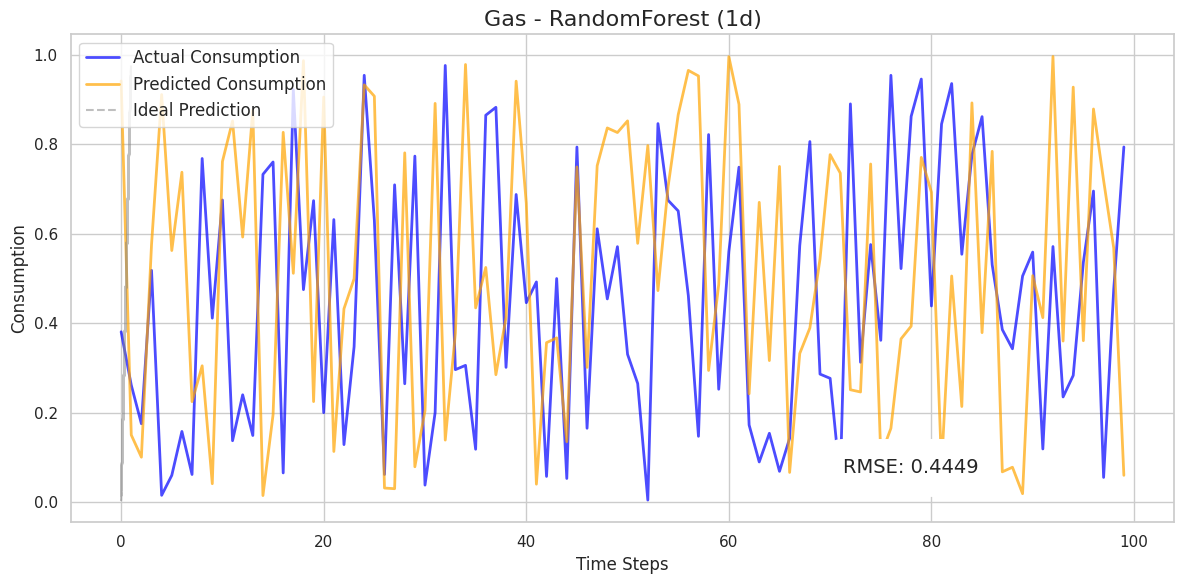

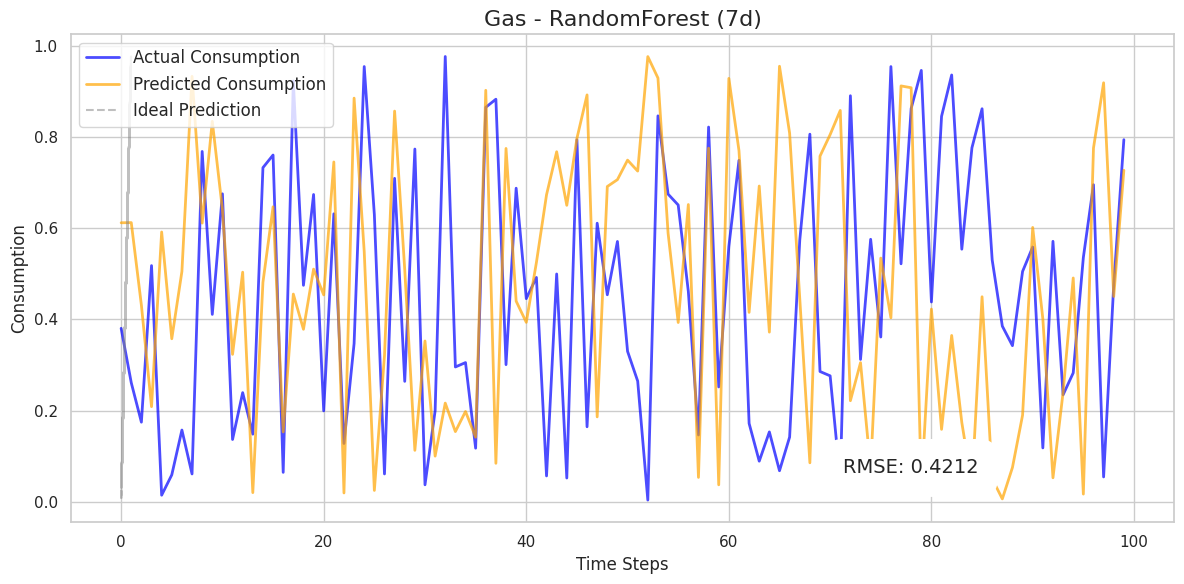

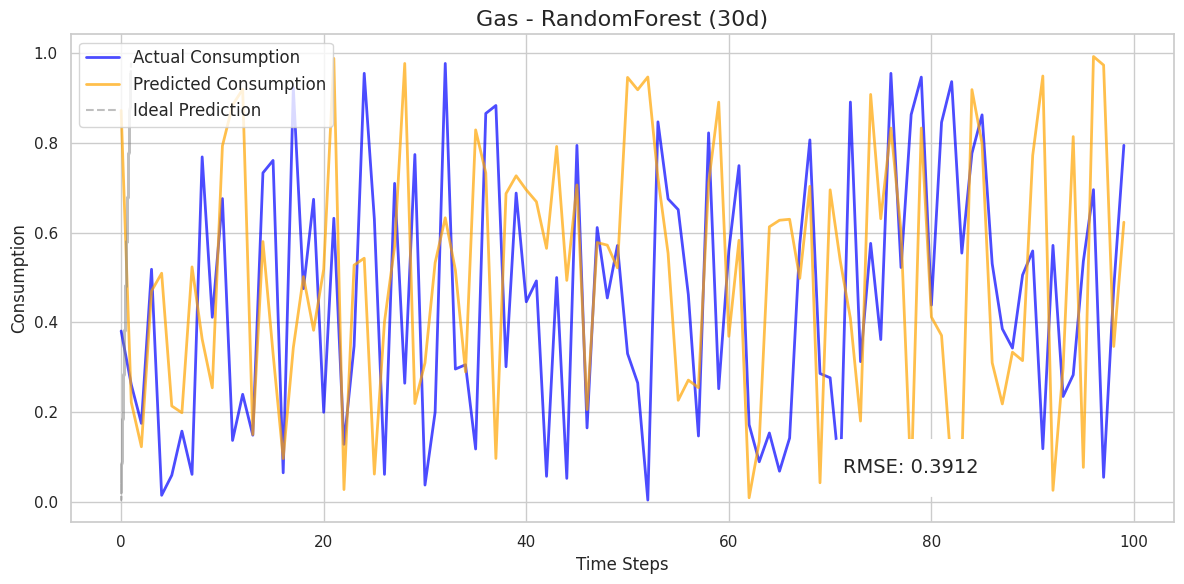

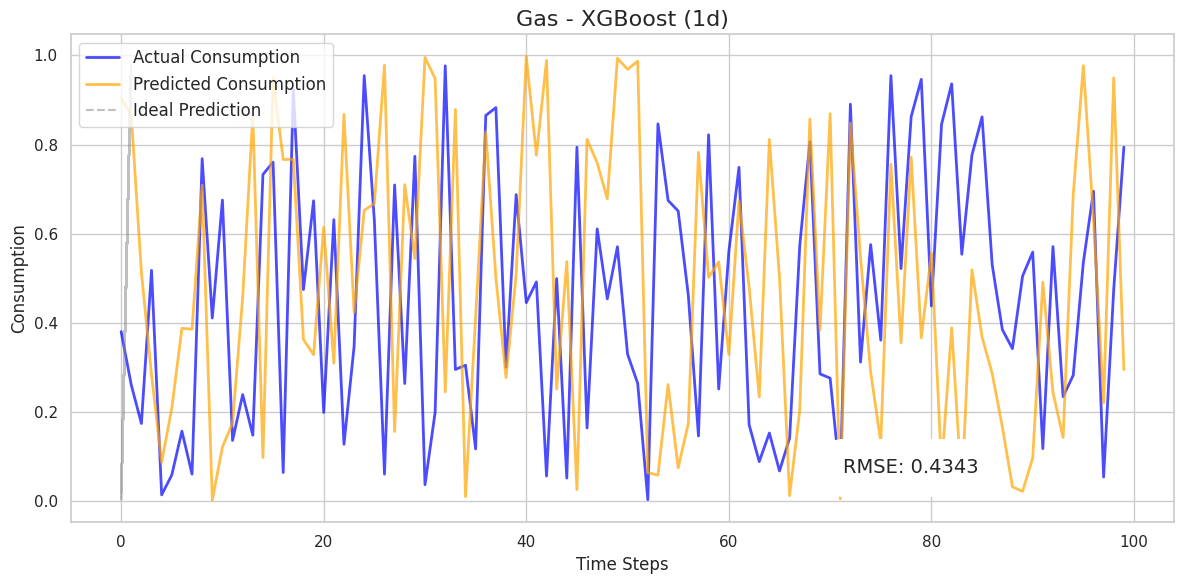

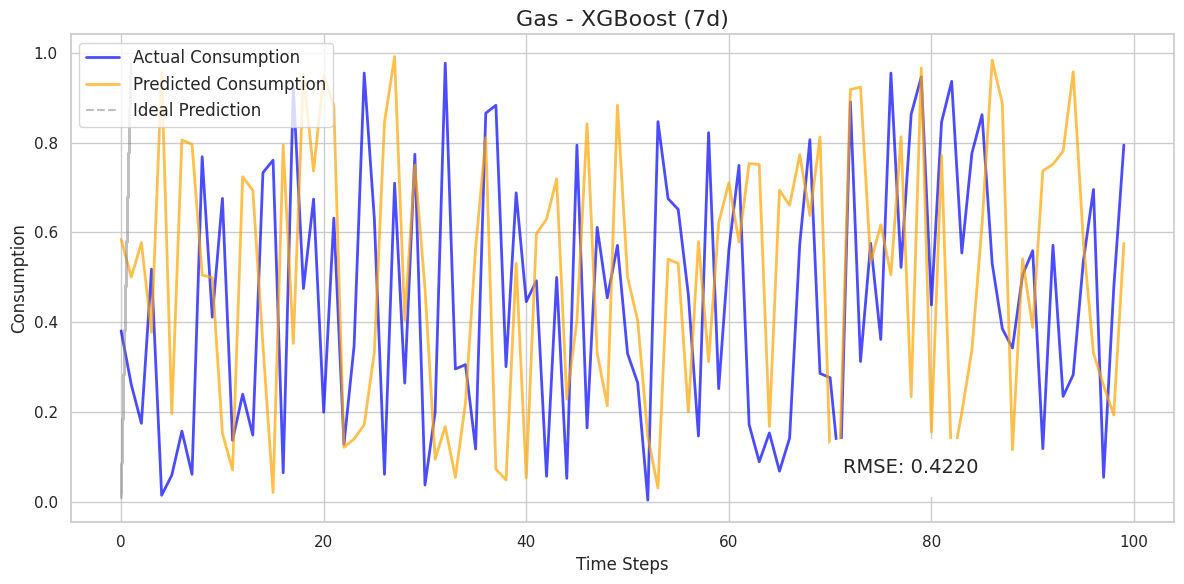

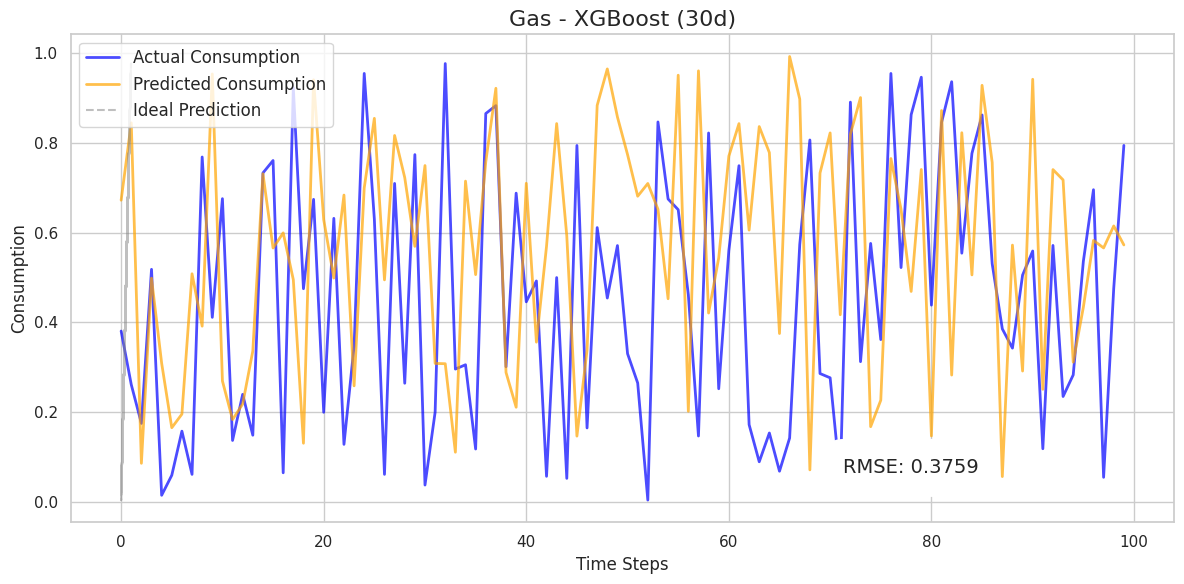

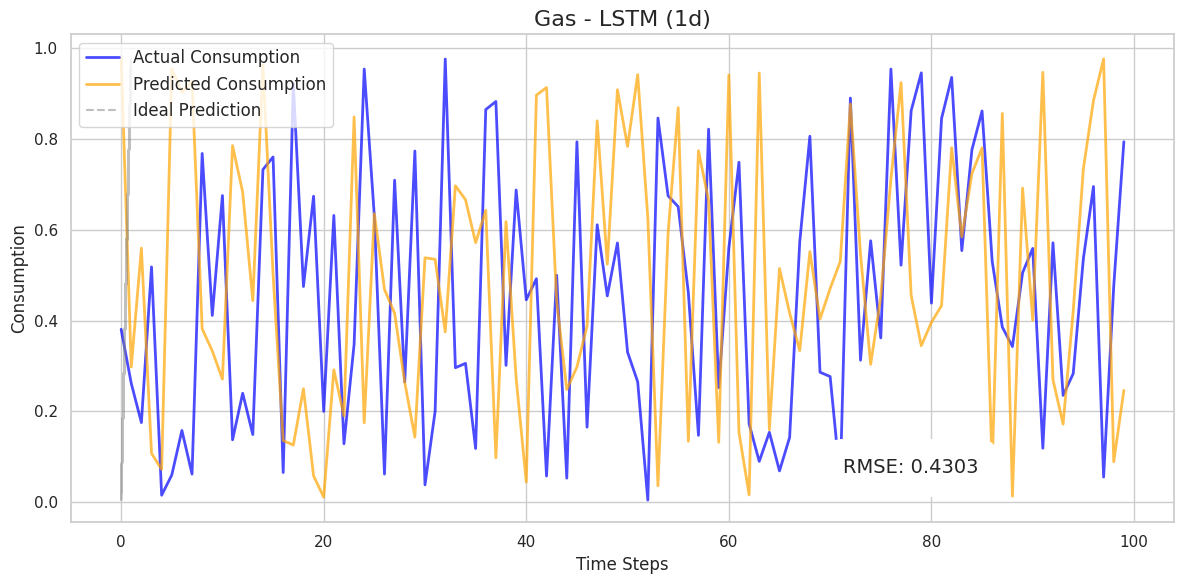

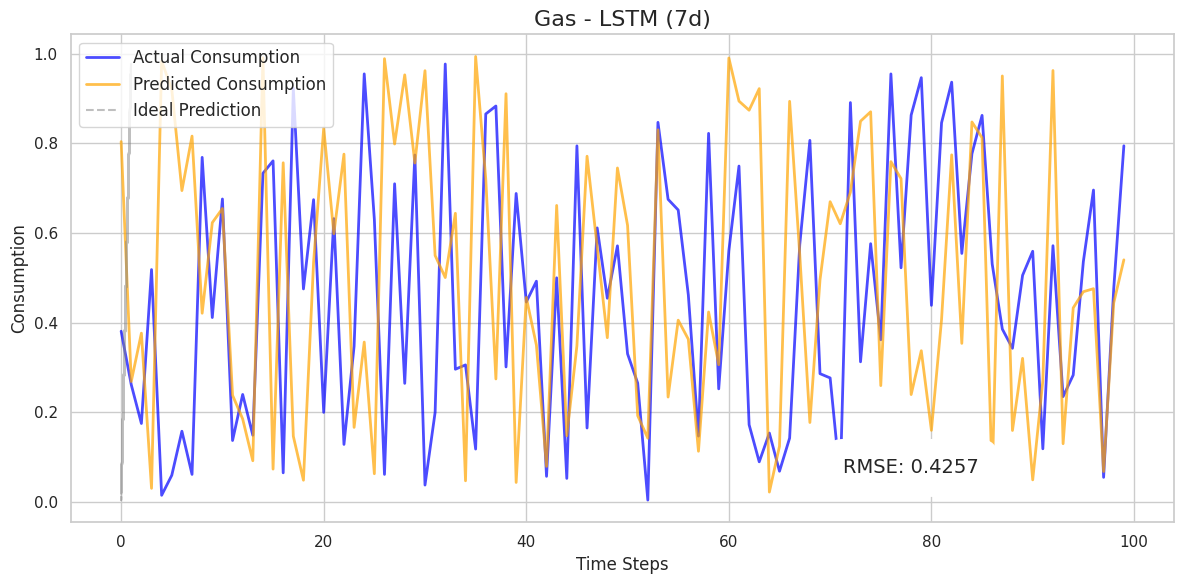

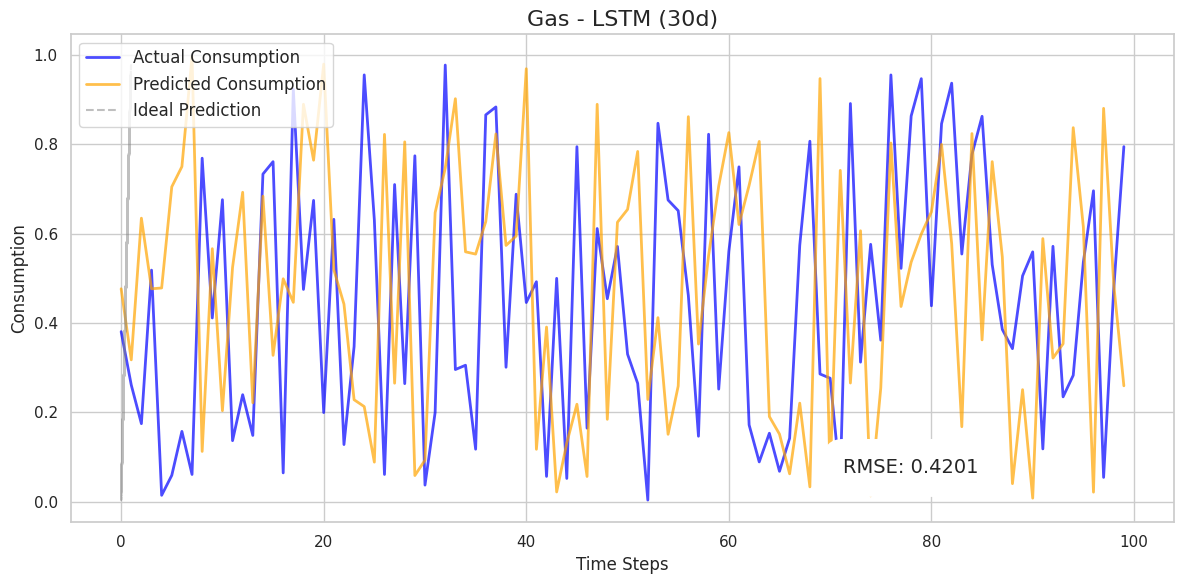

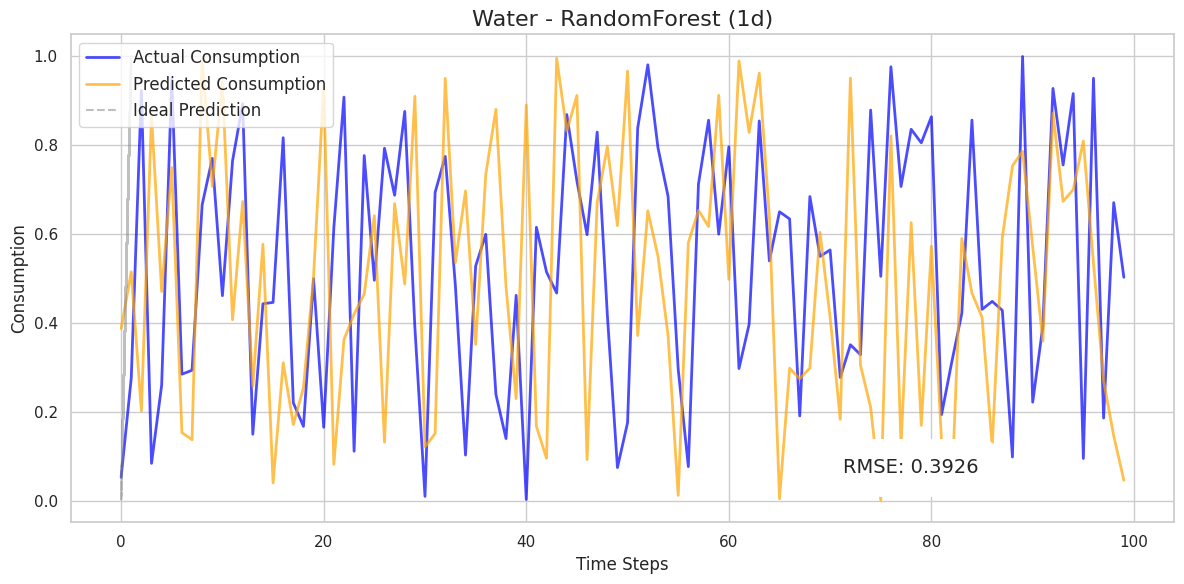

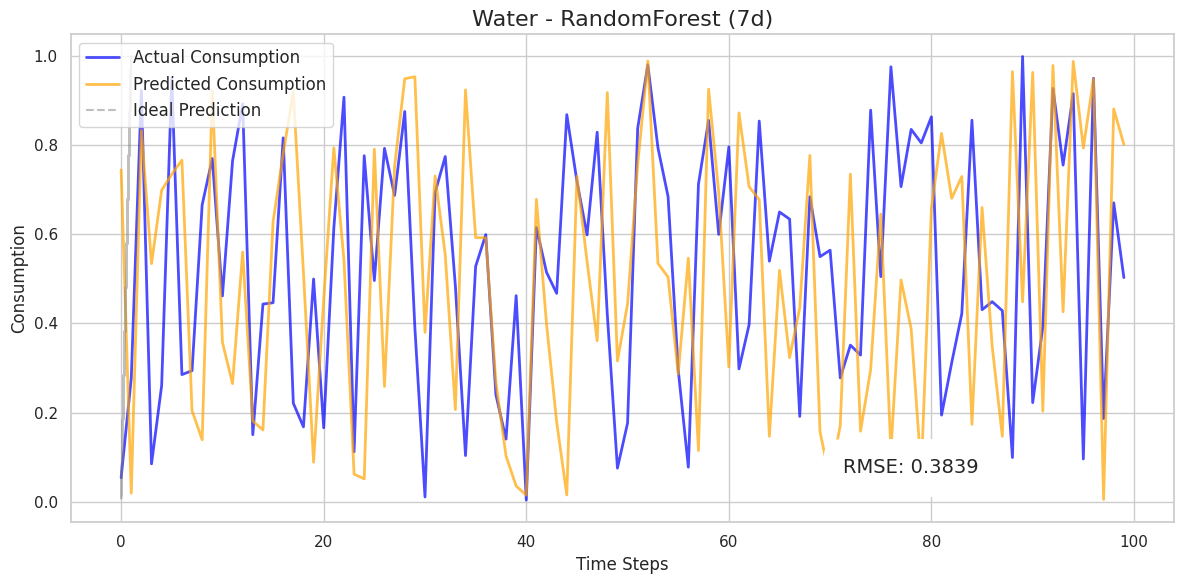

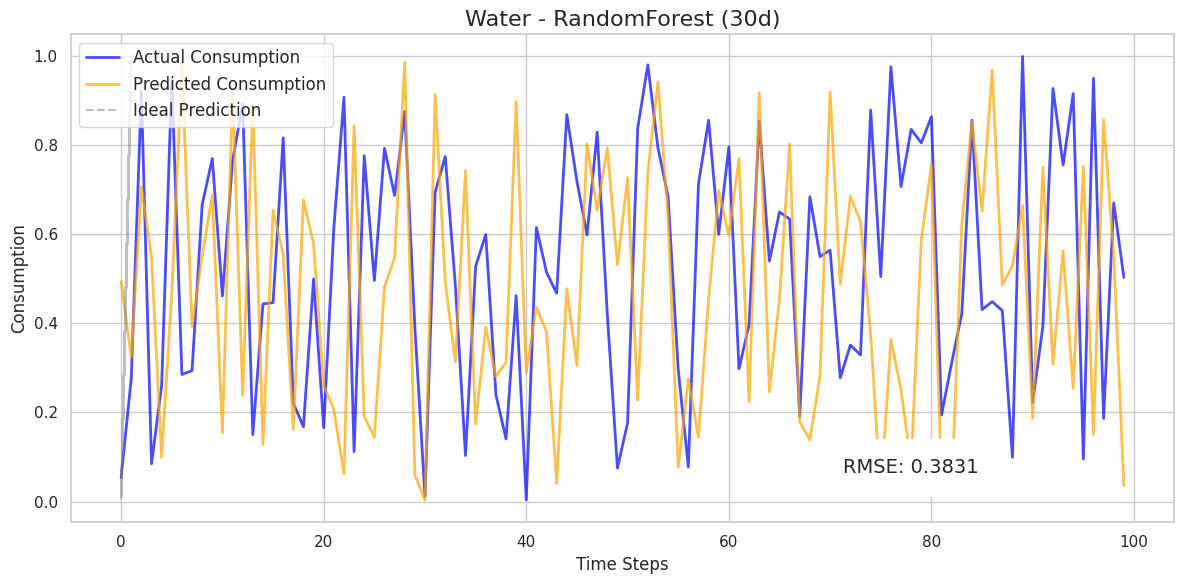

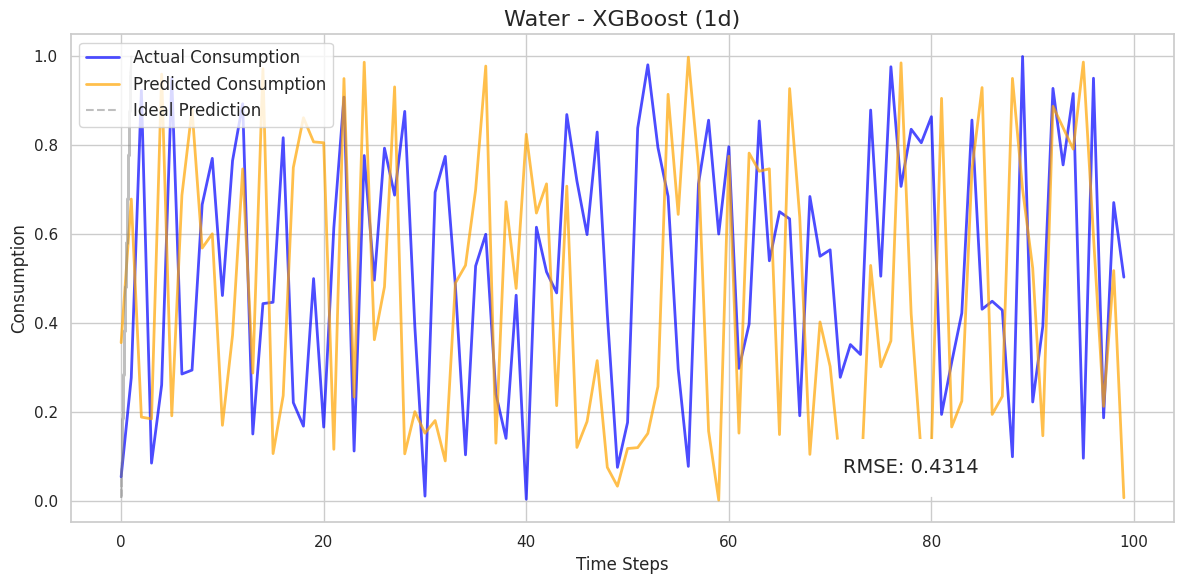

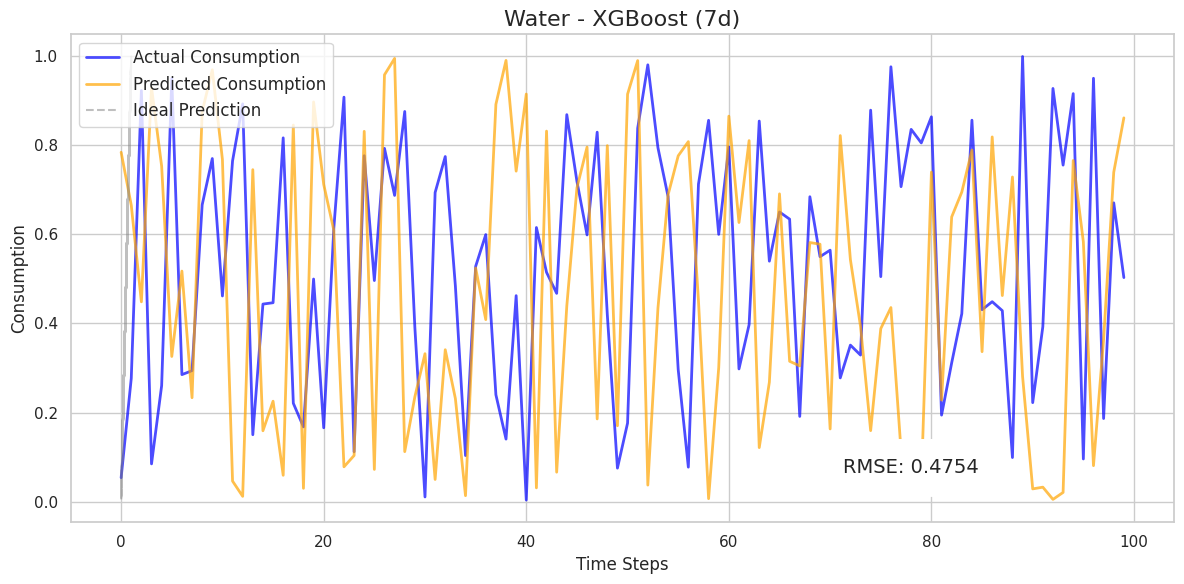

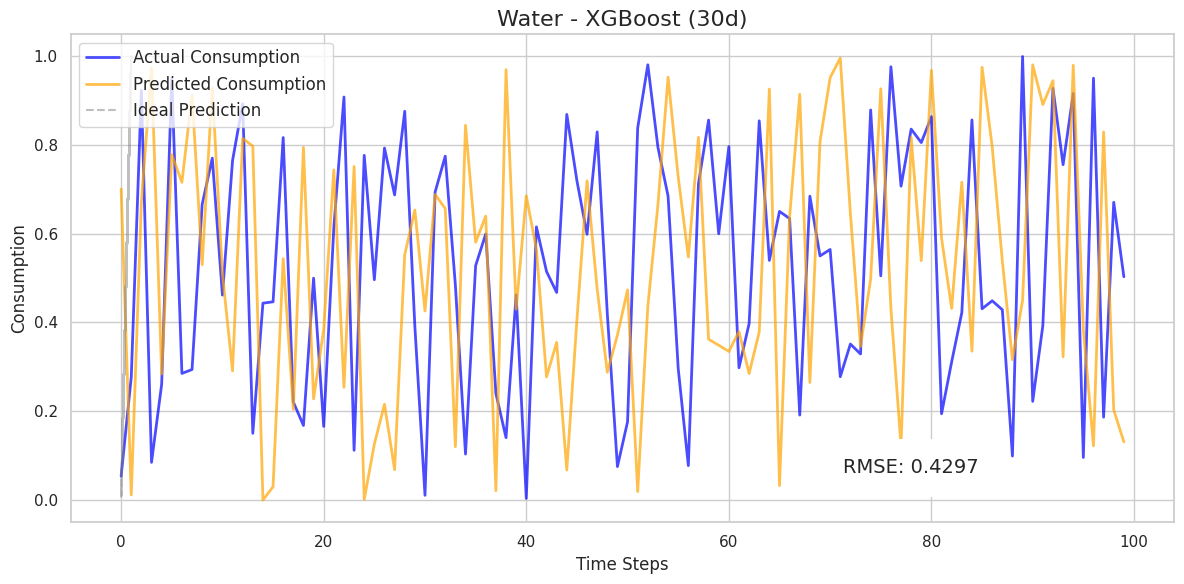

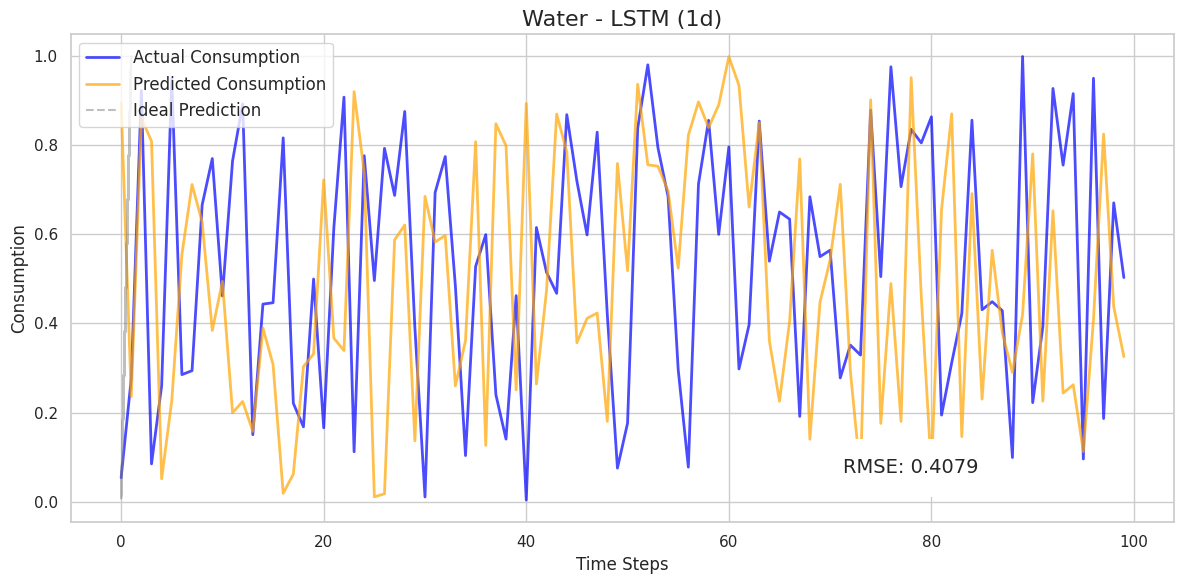

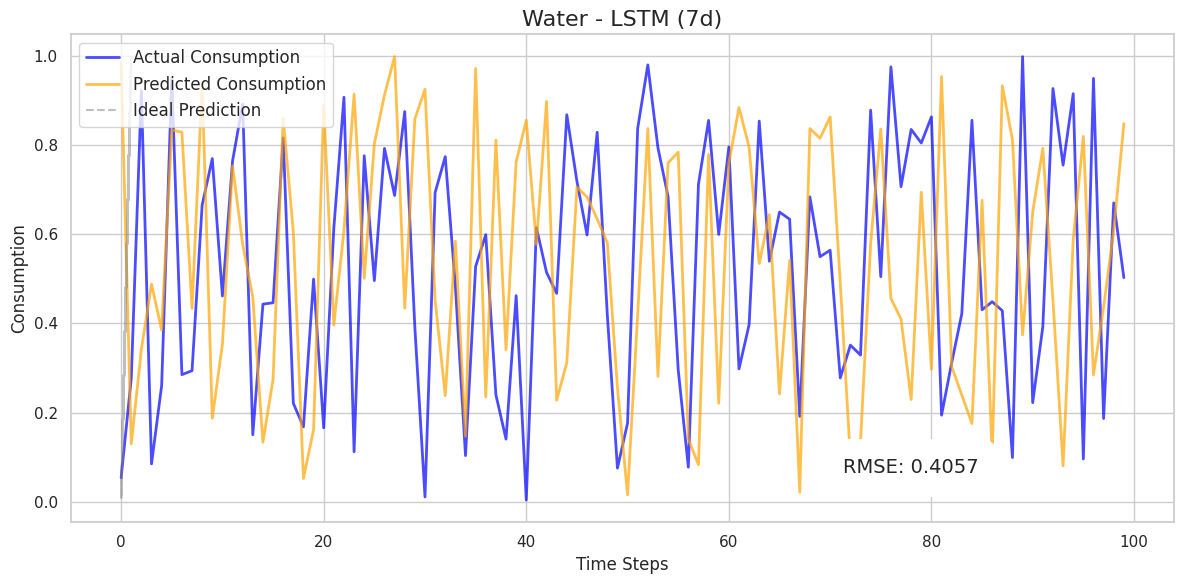

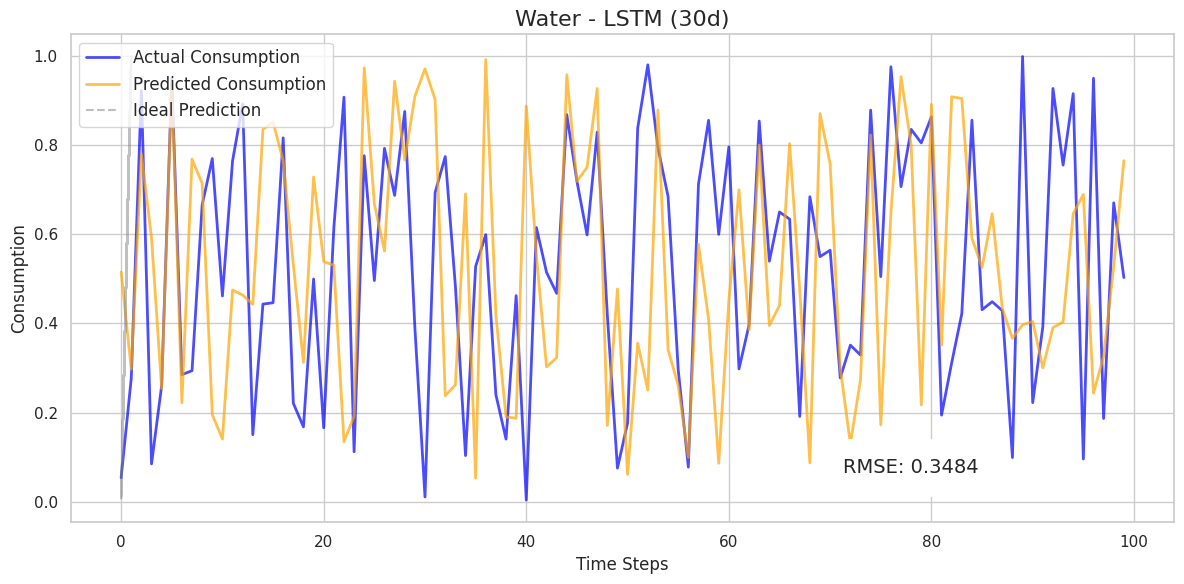

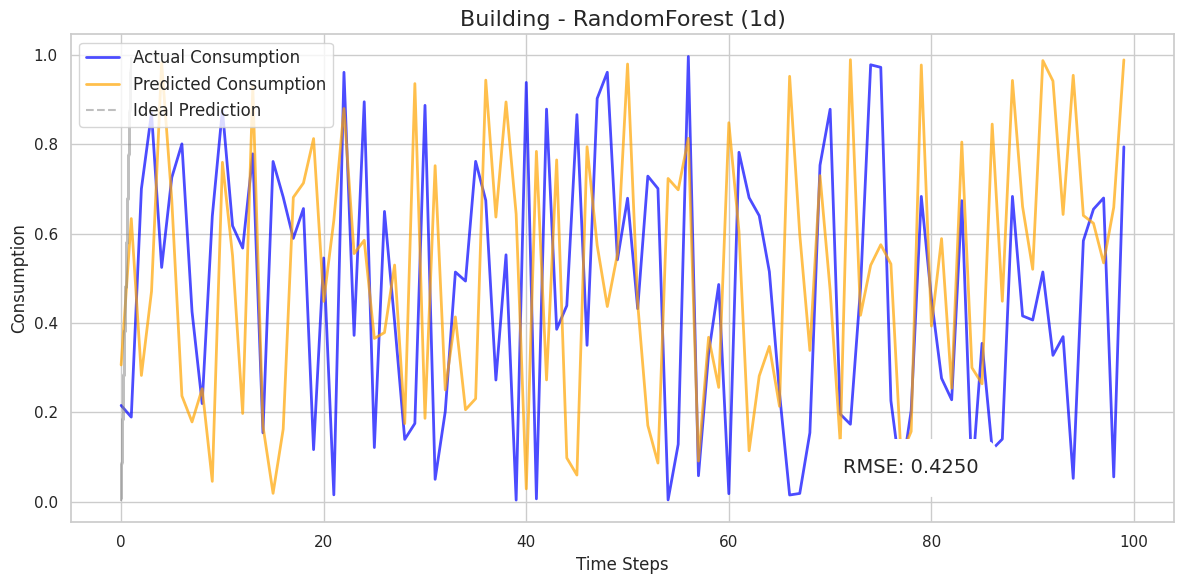

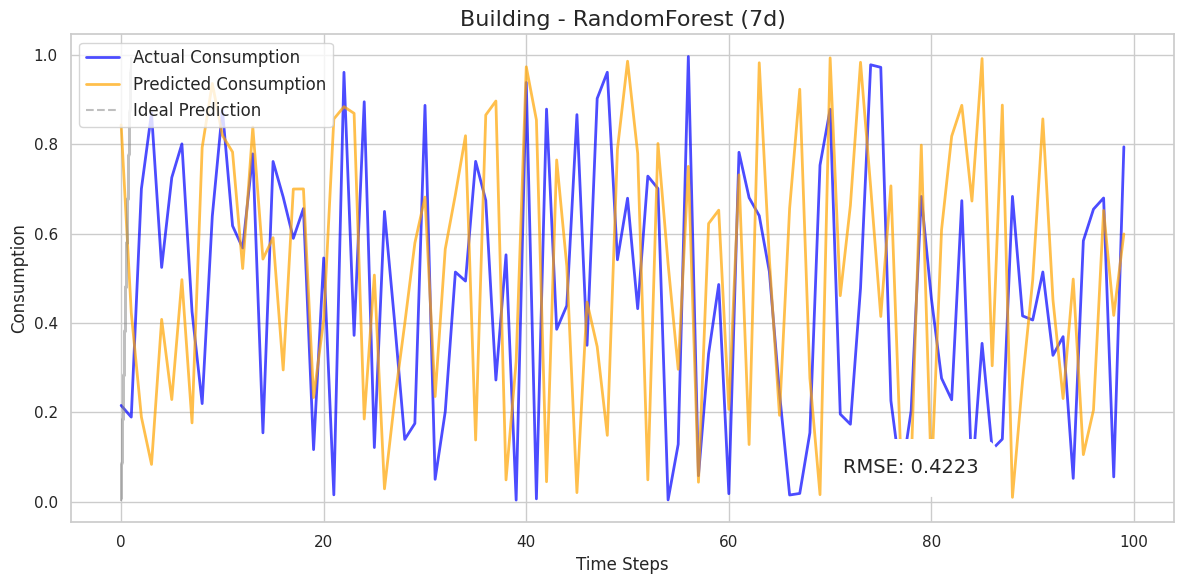

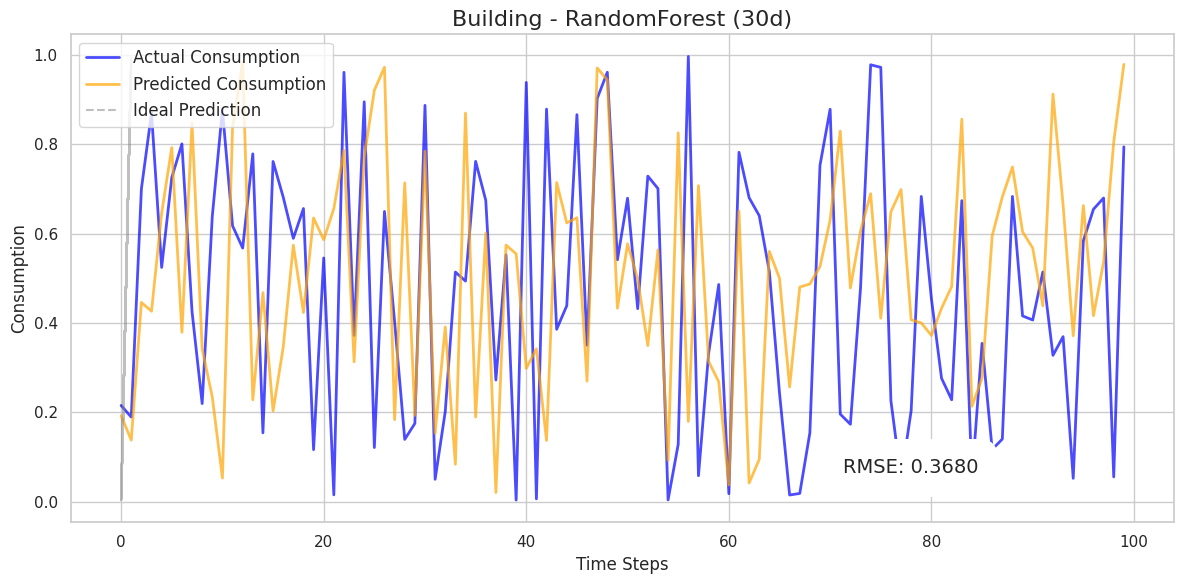

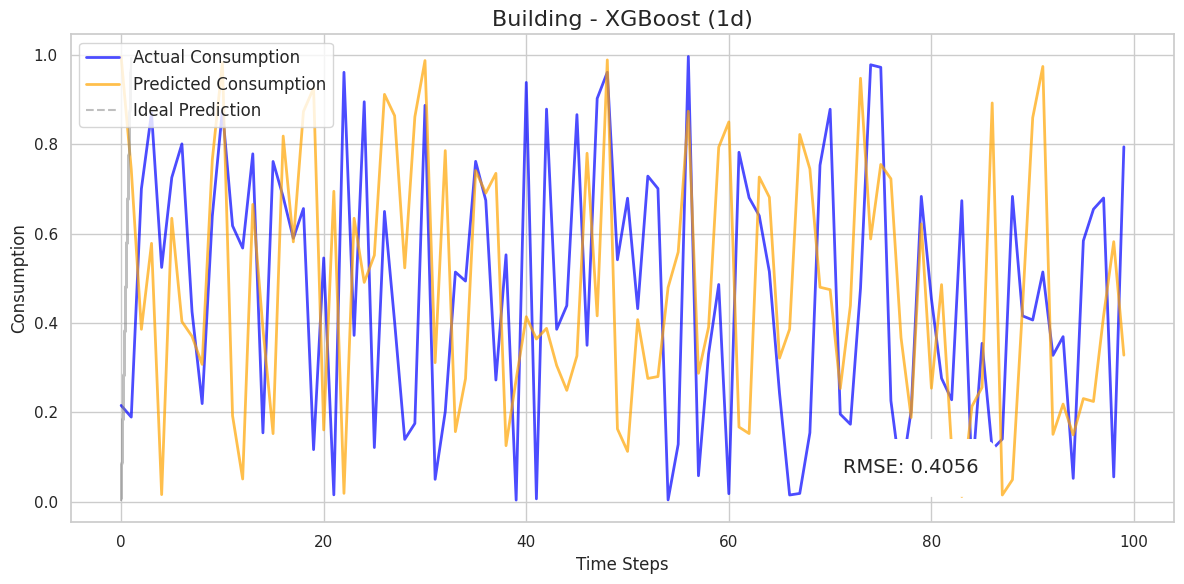

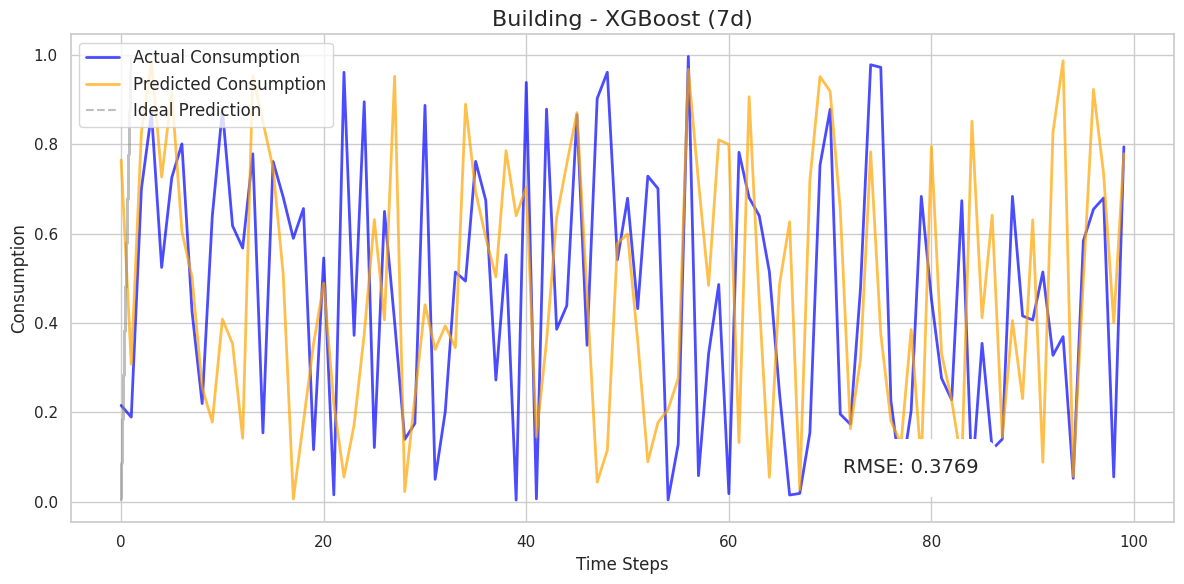

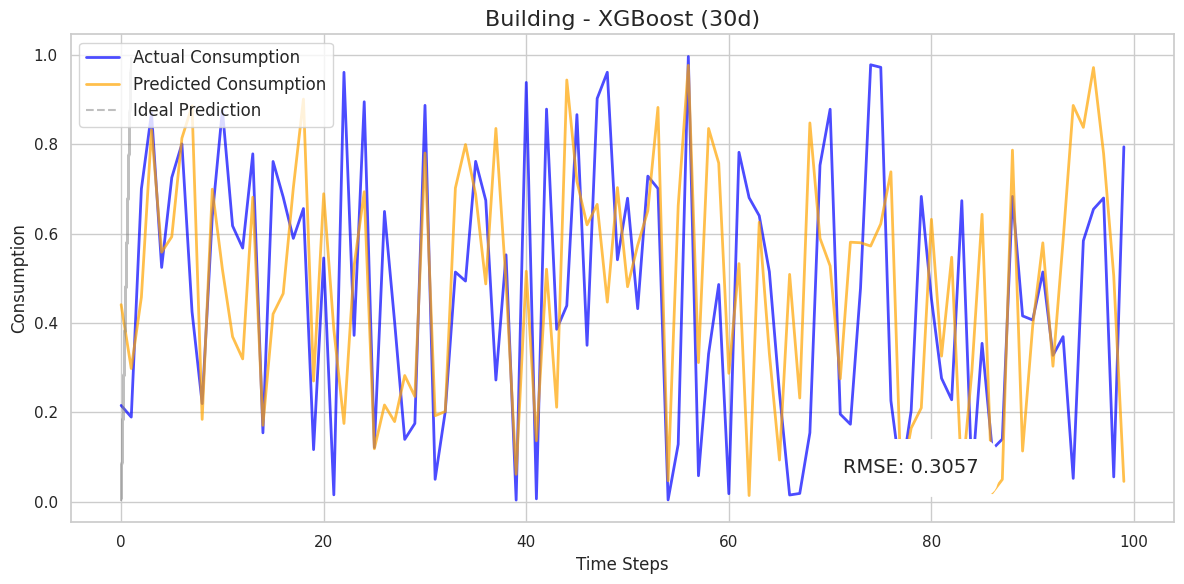

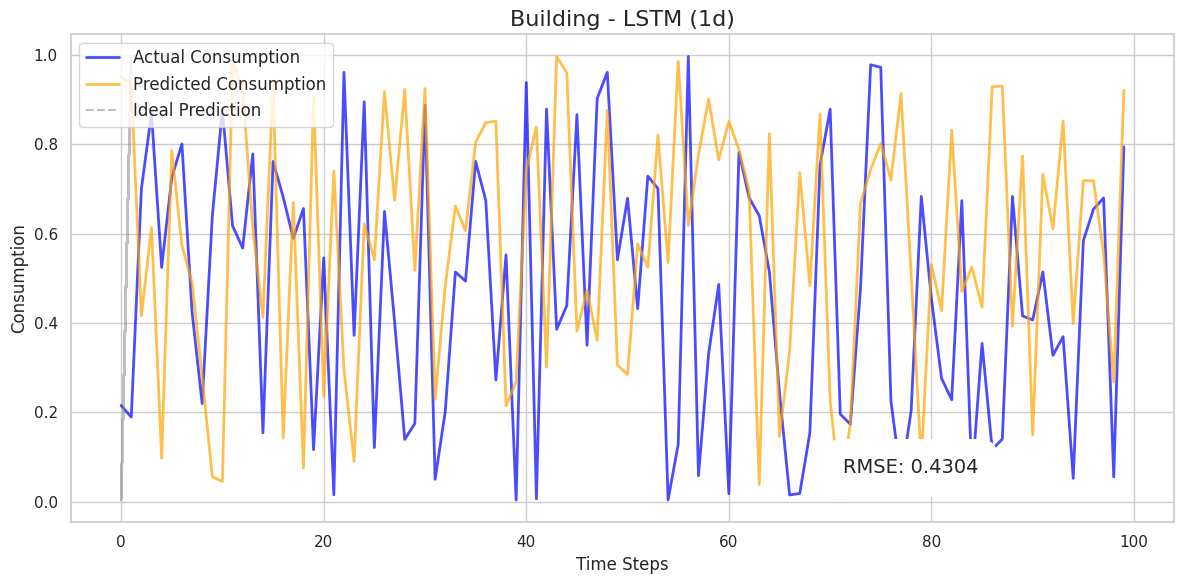

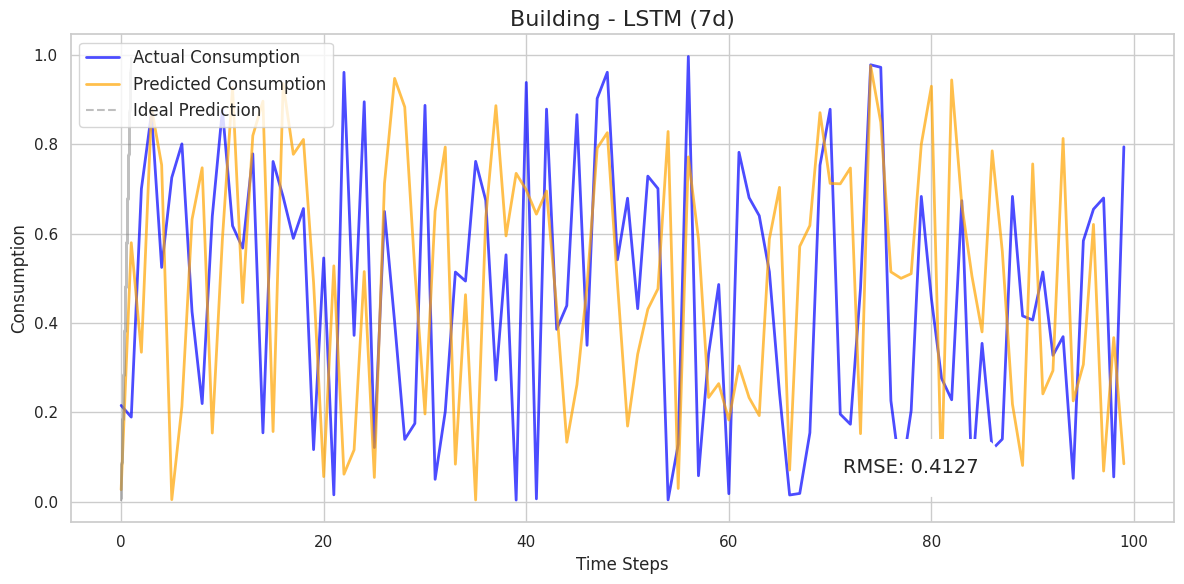

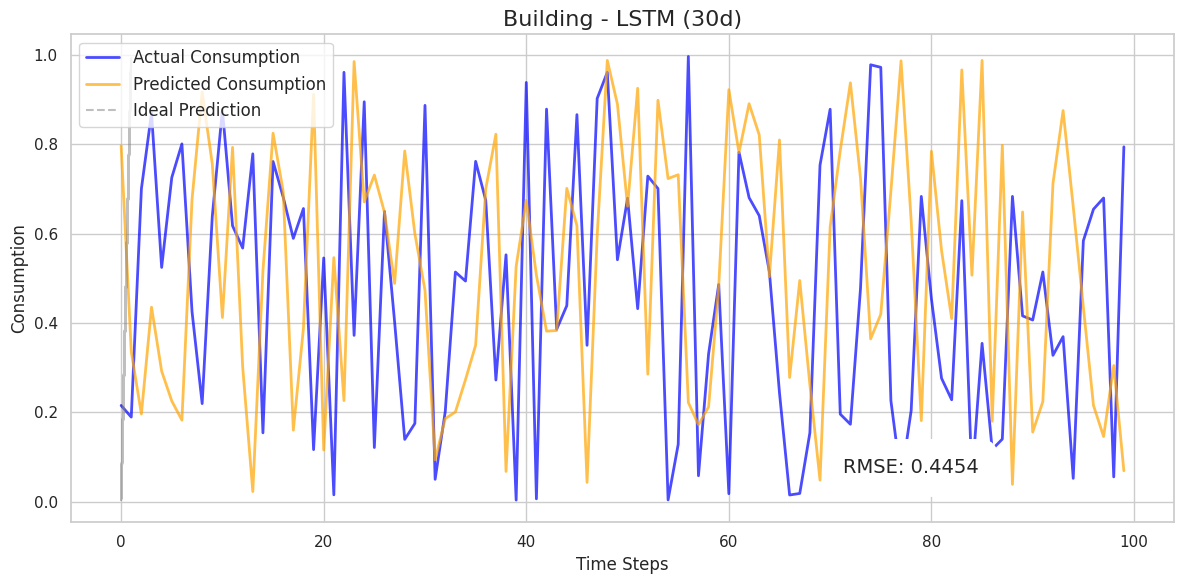

RMSE Results for All Models, Datasets, and Time Periods:
     Dataset         Model Horizon      RMSE
0        Gas  RandomForest      1d  0.444910
1        Gas  RandomForest      7d  0.421163
2        Gas  RandomForest     30d  0.391249
3        Gas       XGBoost      1d  0.434299
4        Gas       XGBoost      7d  0.422023
5        Gas       XGBoost     30d  0.375895
6        Gas          LSTM      1d  0.430343
7        Gas          LSTM      7d  0.425671
8        Gas          LSTM     30d  0.420148
9      Water  RandomForest      1d  0.392587
10     Water  RandomForest      7d  0.383935
11     Water  RandomForest     30d  0.383141
12     Water       XGBoost      1d  0.431372
13     Water       XGBoost      7d  0.475409
14     Water       XGBoost     30d  0.429677
15     Water          LSTM      1d  0.407944
16     Water          LSTM      7d  0.405652
17     Water          LSTM     30d  0.348438
18  Building  RandomForest      1d  0.424992
19  Building  RandomForest      7d  0.42231

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid", palette="muted")

# Define the function to plot actual vs predicted consumption with enhanced visuals
def plot_actual_vs_predicted(df, y_pred, model_name, dataset_name, horizon, identifier='campus_id'):
    """
    Function to plot Actual vs Predicted Consumption with enhanced visualizations.

    Parameters:
    - df: DataFrame containing the actual values (must contain 'consumption' column).
    - y_pred: Array-like, predicted consumption values.
    - model_name: The model used for prediction (e.g., 'RandomForest', 'XGBoost').
    - dataset_name: The name of the dataset (e.g., 'Gas', 'Water', 'Building').
    - horizon: The forecast horizon (e.g., '1d', '7d', '30d').
    - identifier: The identifier column to be used (e.g., 'campus_id', 'meter_id', 'building_id').

    Returns:
    - None
    """
    # Get actual consumption for the corresponding dataset
    y_true = df['consumption'].iloc[-len(y_pred):].values

    plt.figure(figsize=(12, 6))

    # Plot the actual and predicted values
    plt.plot(y_true, label='Actual Consumption', linewidth=2, color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted Consumption', linewidth=2, color='orange', alpha=0.7)

    # Add a best-fit line (optional)
    plt.plot(y_true, y_true, '--', color='gray', label='Ideal Prediction', alpha=0.5)

    # Add titles and labels
    plt.title(f'{dataset_name} - {model_name} ({horizon})', fontsize=16)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Consumption', fontsize=12)

    # Add a legend
    plt.legend(loc='upper left', fontsize=12)

    # Show RMSE as an annotation on the plot
    rmse = calculate_rmse(y_true, y_pred)
    plt.annotate(f'RMSE: {rmse:.4f}', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=14,
                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=1'))

    # Enhance grid and layout
    plt.grid(True)
    plt.tight_layout()

    # Display the plot
    plt.show()

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Placeholder for predicted values (replace these with your actual model predictions)
predictions = {
    'Gas': {
        'RandomForest': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'XGBoost': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'LSTM': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        }
    },
    'Water': {
        'RandomForest': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'XGBoost': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'LSTM': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        }
    },
    'Building': {
        'RandomForest': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'XGBoost': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        },
        'LSTM': {
            '1d': np.random.rand(100),
            '7d': np.random.rand(100),
            '30d': np.random.rand(100)
        }
    }
}

# Replace with your actual dataframes containing actual values for Gas, Water, and Building
df_gas = pd.DataFrame({'consumption': np.random.rand(100)})
df_water = pd.DataFrame({'consumption': np.random.rand(100)})
df_building = pd.DataFrame({'consumption': np.random.rand(100)})

# Calculate RMSE and plot for each model and each dataset
rmse_results = []

for dataset in ['Gas', 'Water', 'Building']:
    for model in ['RandomForest', 'XGBoost', 'LSTM']:
        for horizon in ['1d', '7d', '30d']:
            # Get actual consumption data for the last 100 records
            if dataset == 'Gas':
                y_true = df_gas['consumption'].iloc[-100:].values
            elif dataset == 'Water':
                y_true = df_water['consumption'].iloc[-100:].values
            elif dataset == 'Building':
                y_true = df_building['consumption'].iloc[-100:].values

            # Get predicted values for the current model and horizon
            y_pred = predictions[dataset][model][horizon]

            # Calculate RMSE
            rmse = calculate_rmse(y_true, y_pred)

            # Store the results
            rmse_results.append({
                'Dataset': dataset,
                'Model': model,
                'Horizon': horizon,
                'RMSE': rmse
            })

            # Plot actual vs predicted
            plot_actual_vs_predicted(
                df_gas if dataset == 'Gas' else df_water if dataset == 'Water' else df_building,
                y_pred,
                model_name=model,
                dataset_name=dataset,
                horizon=horizon
            )

# Convert RMSE results to DataFrame for easy comparison
df_rmse = pd.DataFrame(rmse_results)

# Display RMSE results
print("RMSE Results for All Models, Datasets, and Time Periods:")
print(df_rmse)

# Find the best model based on RMSE (lowest RMSE)
best_model_row = df_rmse.loc[df_rmse['RMSE'].idxmin()]
print(f"\nBest Model: {best_model_row['Model']} for {best_model_row['Dataset']} ({best_model_row['Horizon']}) with RMSE: {best_model_row['RMSE']}")


In [58]:
def plot_residuals(df, y_pred, model_name, dataset_name, horizon):
    """
    Plot residuals (Actual - Predicted).
    """
    y_true = df['consumption']
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='red')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Residuals for {model_name} - {dataset_name} - {horizon}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


In [59]:
def plot_rmse_over_time(df_rmse):
    """
    Plot RMSE over different time periods (1d, 7d, 30d).
    """
    plt.figure(figsize=(12, 6))
    for dataset in df_rmse['Dataset'].unique():
        for model in df_rmse['Model'].unique():
            subset = df_rmse[(df_rmse['Dataset'] == dataset) & (df_rmse['Model'] == model)]
            plt.plot(subset['Horizon'], subset['RMSE'], label=f'{model} - {dataset}')

    plt.title('Model Performance (RMSE) Over Time Periods', fontsize=14)
    plt.xlabel('Horizon (Time Period)', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


In [60]:
def plot_cumulative_error(df, y_pred, model_name, dataset_name, horizon):
    """
    Plot cumulative prediction error over time.
    """
    y_true = df['consumption'].iloc[-len(y_pred):].values
    residuals = y_true - y_pred
    cumulative_error = np.cumsum(residuals)

    plt.figure(figsize=(12, 5))
    plt.plot(cumulative_error, label='Cumulative Error', color='purple')
    plt.title(f'Cumulative Error for {model_name} - {dataset_name} - {horizon}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Cumulative Error', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
